In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.formula.api import ols
from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.api import VAR

In [2]:
velocity_M1 = pd.read_csv('M1V.csv', index_col = 0)
velocity_M1.index = pd.to_datetime(velocity_M1.index)

velocity_M2 = pd.read_csv('M2V.csv', index_col = 0)
velocity_M2.index = pd.to_datetime(velocity_M2.index)

velocity_M1 = velocity_M1.resample('Y').mean().loc[:'2018']
velocity_M2 = velocity_M2.resample('Y').mean().loc[:'2018']

In [3]:
mkt_cap = pd.read_csv('market_cap_usa.csv', sep = ';')
mkt_cap = mkt_cap.T.loc['1980':'2018']
mkt_cap.columns = ['MktCap']
mkt_cap.index = pd.to_datetime(mkt_cap.index)
mkt_cap['MktCap'] = mkt_cap['MktCap'].astype(float)

In [4]:
m2_data = pd.read_csv('M2_money_stock.csv', index_col = 0)
m1_data = pd.read_csv('M1_money_stock.csv', index_col = 0)
m0_data = pd.read_csv('monetary_base_curr_in_circulation.csv', index_col = 0)
gdp_data = pd.read_csv('GDP.csv', index_col = 0)

m2_data.index = pd.to_datetime(m2_data.index)
m2_data.columns = ['M2']
m2_data = m2_data.resample('Y').mean().loc[:'2018']

m1_data.index = pd.to_datetime(m1_data.index)
m1_data.columns = ['M1']
m1_data = m1_data.resample('Y').mean().loc[:'2018']

m0_data.index = pd.to_datetime(m0_data.index)
m0_data.columns = ['M0']
m0_data = m0_data.resample('Y').mean().loc[:'2018']

gdp_data.index = pd.to_datetime(gdp_data.index)
gdp_data.columns = ['GDP']
gdp_data = gdp_data.resample('Y').mean().loc[:'2018']

In [5]:
inflation_data = pd.read_csv('CPIAUCSL.csv', index_col = 0)
inflation_data.index = pd.to_datetime(inflation_data.index)
inflation_data.columns = ['inflation']

In [6]:
inflation_data_r = inflation_data.resample('Y').last()

In [7]:
test_data = inflation_data_r.join(mkt_cap, how = 'outer')
test_data['MktCap'] = test_data['MktCap'].fillna(method = 'ffill')
test_data = test_data.dropna()

test_data = test_data.join(m2_data)
test_data = test_data.join(m1_data)
test_data = test_data.join(m0_data)
test_data = test_data.join(gdp_data)
test_data = test_data.join(velocity_M1)
test_data = test_data.join(velocity_M2)

print(test_data.head(3))

            inflation        MktCap           M2          M1             M0  \
1980-12-31       86.4  1.359798e+12  1601.088889  395.671154  127541.666667   
1981-12-31       94.1  1.263561e+12  1678.838462  424.721154  137466.666667   
1982-12-31       97.7  1.456865e+12  1829.963462  452.748077  147466.666667   

                   GDP      M1V      M2V  
1980-12-31  2857.30850  7.22075  1.85525  
1981-12-31  3207.04125  7.54625  1.91025  
1982-12-31  3343.78925  7.38350  1.82675  


In [8]:
test_data_log_diff = np.log(test_data) - np.log(test_data).shift(1)
test_data_log_diff = test_data_log_diff.dropna()
for col in test_data_log_diff.columns:
    print(col, adfuller(test_data_log_diff[col].values)[1])

inflation 0.02674860485527895
MktCap 5.36082125877159e-10
M2 0.05592024984262006
M1 0.07856074994268304
M0 0.0005118237553102041
GDP 0.0002605168315555126
M1V 0.02898692399238875
M2V 0.001502837033158367


## Granger Causality

In [9]:
data = test_data_log_diff[['inflation', 'MktCap']]
gc_res = grangercausalitytests(data, 3)
gc_res


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0361  , p=0.8505  , df_denom=34, df_num=1
ssr based chi2 test:   chi2=0.0393  , p=0.8429  , df=1
likelihood ratio test: chi2=0.0392  , p=0.8430  , df=1
parameter F test:         F=0.0361  , p=0.8505  , df_denom=34, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1504  , p=0.8610  , df_denom=31, df_num=2
ssr based chi2 test:   chi2=0.3494  , p=0.8397  , df=2
likelihood ratio test: chi2=0.3477  , p=0.8404  , df=2
parameter F test:         F=0.1504  , p=0.8610  , df_denom=31, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2542  , p=0.8577  , df_denom=28, df_num=3
ssr based chi2 test:   chi2=0.9534  , p=0.8125  , df=3
likelihood ratio test: chi2=0.9406  , p=0.8156  , df=3
parameter F test:         F=0.2542  , p=0.8577  , df_denom=28, df_num=3


{1: ({'ssr_ftest': (0.03607125589636708, 0.8504977979952043, 34.0, 1),
   'ssr_chi2test': (0.03925401376957594, 0.8429462817907549, 1),
   'lrtest': (0.03923320581503731, 0.8429873715261069, 1),
   'params_ftest': (0.03607125589636955, 0.8504977979952043, 34.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.15041818427362053, 0.8609722431207676, 31.0, 2),
   'ssr_chi2test': (0.3493583634742154, 0.8397263771172908, 2),
   'lrtest': (0.34767409477706224, 0.8404338373893544, 2),
   'params_ftest': (0.15041818427362763, 0.8609722431207617, 31.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.2542267420053502, 0.8576550313003078, 28.0, 3),
   'ssr_chi2test': (0.9533502825200635, 0.8125377270131335, 3),
   'lrtest': (0.9405973910651824, 0.8156212935549606, 3),
   'params_ftest': (0.2542267420053476, 0.8576550313003093, 28.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0.,

In [10]:
data_inv = test_data_log_diff[['MktCap', 'inflation']]
gc_res_inv = grangercausalitytests(data_inv, 3)
gc_res_inv


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1088  , p=0.7436  , df_denom=34, df_num=1
ssr based chi2 test:   chi2=0.1184  , p=0.7308  , df=1
likelihood ratio test: chi2=0.1182  , p=0.7310  , df=1
parameter F test:         F=0.1088  , p=0.7436  , df_denom=34, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1988  , p=0.8207  , df_denom=31, df_num=2
ssr based chi2 test:   chi2=0.4617  , p=0.7938  , df=2
likelihood ratio test: chi2=0.4588  , p=0.7950  , df=2
parameter F test:         F=0.1988  , p=0.8207  , df_denom=31, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0374  , p=0.9901  , df_denom=28, df_num=3
ssr based chi2 test:   chi2=0.1404  , p=0.9866  , df=3
likelihood ratio test: chi2=0.1401  , p=0.9866  , df=3
parameter F test:         F=0.0374  , p=0.9901  , df_denom=28, df_num=3


{1: ({'ssr_ftest': (0.10878155625114586, 0.7435591218727227, 34.0, 1),
   'ssr_chi2test': (0.11837992886154107, 0.7307982729453613, 1),
   'lrtest': (0.1181909560501424, 0.7310048863150549, 1),
   'params_ftest': (0.10878155625114062, 0.7435591218727314, 34.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.19880521951517705, 0.8207464356432992, 31.0, 2),
   'ssr_chi2test': (0.46174115500299184, 0.7938422004280258, 2),
   'lrtest': (0.45880505515569325, 0.7950084562611904, 2),
   'params_ftest': (0.19880521951517874, 0.8207464356432977, 31.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.037437691371087115, 0.9900983609326295, 28.0, 3),
   'ssr_chi2test': (0.14039134264157666, 0.9865843579255654, 3),
   'lrtest': (0.1401105257709503, 0.9866234718161244, 3),
   'params_ftest': (0.03743769137108761, 0.9900983609326292, 28.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0.,

## VAR ANALYSIS

### VAR: inflation, MktCap

In [11]:
model = VAR(test_data_log_diff[['inflation', 'MktCap']])
results = model.fit(4)
results.summary()

/Users/felipe/anaconda/envs/fenicsproject/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  warnings.warn('No frequency information was'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 21, Apr, 2021
Time:                     08:56:28
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -10.8391
Nobs:                     34.0000    HQIC:                  -11.3716
Log likelihood:           119.514    FPE:                8.97272e-06
AIC:                     -11.6471    Det(Omega_mle):     5.60977e-06
--------------------------------------------------------------------
Results for equation inflation
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.011787         0.007160            1.646           0.100
L1.inflation         0.211030         0.201685            1.046           0.295
L1.MktCap           -0.005612         0.013420           -0.

## VAR: inflation, M2, MktCap

In [12]:
model = VAR(test_data_log_diff[['inflation','M2', 'MktCap']])
results = model.fit(4)
results.summary()

/Users/felipe/anaconda/envs/fenicsproject/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  warnings.warn('No frequency information was'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 21, Apr, 2021
Time:                     08:56:28
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -17.9413
Nobs:                     34.0000    HQIC:                  -19.0951
Log likelihood:           229.035    FPE:                3.17045e-09
AIC:                     -19.6922    Det(Omega_mle):     1.20023e-09
--------------------------------------------------------------------
Results for equation inflation
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.010967         0.011325            0.968           0.333
L1.inflation         0.161253         0.204398            0.789           0.430
L1.M2               -0.254747         0.187226           -1.

## VAR: inflation, M2, GDP, MktCap

In [13]:
model = VAR(test_data_log_diff[['inflation','M2','GDP', 'MktCap']])
results = model.fit(4)
results.summary()

/Users/felipe/anaconda/envs/fenicsproject/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  warnings.warn('No frequency information was'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 21, Apr, 2021
Time:                     08:56:28
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -26.1101
Nobs:                     34.0000    HQIC:                  -28.1217
Log likelihood:           370.791    FPE:                3.20683e-13
AIC:                     -29.1628    Det(Omega_mle):     6.33448e-14
--------------------------------------------------------------------
Results for equation inflation
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.001966         0.010614            0.185           0.853
L1.inflation        -0.186881         0.217171           -0.861           0.389
L1.M2               -0.005228         0.189253           -0.

## VAR: inlfation, M2, GDP, MV2, MktCap

In [14]:
model = VAR(test_data_log_diff[['inflation','M2','GDP', 'M2V', 'MktCap']])
results = model.fit(4)
results.summary()

/Users/felipe/anaconda/envs/fenicsproject/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  warnings.warn('No frequency information was'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 21, Apr, 2021
Time:                     08:56:28
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -41.2908
Nobs:                     34.0000    HQIC:                  -44.3971
Log likelihood:           645.859    FPE:                2.95219e-20
AIC:                     -46.0046    Det(Omega_mle):     2.66517e-21
--------------------------------------------------------------------
Results for equation inflation
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const               -0.015012         0.012251           -1.225           0.220
L1.inflation        -0.126715         0.239454           -0.529           0.597
L1.M2              -26.398851         8.439568           -3.

In [15]:
model = VAR(test_data_log_diff[['inflation','M2','GDP', 'M2V']])
results = model.fit(4)
results.summary()

/Users/felipe/anaconda/envs/fenicsproject/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  warnings.warn('No frequency information was'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 21, Apr, 2021
Time:                     08:56:28
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -38.6245
Nobs:                     34.0000    HQIC:                  -40.6361
Log likelihood:           583.537    FPE:                1.17794e-18
AIC:                     -41.6772    Det(Omega_mle):     2.32680e-19
--------------------------------------------------------------------
Results for equation inflation
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const               -0.008107         0.011899           -0.681           0.496
L1.inflation        -0.065662         0.199438           -0.329           0.742
L1.M2              -19.885731         7.266449           -2.

In [16]:
data_shifted = test_data_log_diff[['M2', 'GDP', 'M2V']].shift(-1)
data_reg = data_shifted.join(test_data_log_diff['inflation'], how = 'inner').dropna()
model = ols("inflation ~ M2 + M2V + GDP", data_reg).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              inflation   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     1.370
Date:                Wed, 21 Apr 2021   Prob (F-statistic):              0.269
Time:                        08:56:28   Log-Likelihood:                 103.96
No. Observations:                  37   AIC:                            -199.9
Df Residuals:                      33   BIC:                            -193.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0148      0.010      1.548      0.131      -0.005       0.034
M2             5.4227      6.247      0.868      0.392      -7.287      18.132
M2V            5.3879      6.253      0.862      0.395      -7.334      18.110
GDP           -5.1549      6.246     -0.825      0.415     -17.863       7.554
==============================================================================
Omnibus:                       31.370   Durbin-Watson:                   1.267
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.699
Skew:                           2.039   Prob(JB):                     2.21e-17
Kurtosis:                       8.755   Cond. No.                     4.28e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.28e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

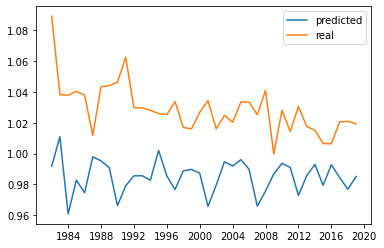

In [17]:
import matplotlib.pyplot as plt
data_sum = np.exp((data_shifted * np.array([-26.4, 26.4, -26.4])).sum(axis=1) - 0.015012)


plt.plot(data_sum, label = 'predicted')
plt.plot(np.exp(test_data_log_diff['inflation']), label = 'real')
plt.legend()